# Requirements

In [ ]:
!pip install matplotlib==3.1.0

In [ ]:
!pip install hazm
!pip install stopwords_guilannlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=c628a44e03906844c8e631d1741582d4046d05f43a22c2f7fd8b9e06fad18a11
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=154668 sha256=87853a6dc3a1634fb97f8f8d0b15c27a8ada9cb64f8906dd29e2b8e92170b507
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting unin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get FastText

Download FastText word vectors file for Persian

(The list of all model vector files are available [here](https://fasttext.cc/docs/en/pretrained-vectors.html))

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec

--2023-01-06 19:36:46--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105157170 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.fa.vec’

wiki.fa.vec         100%[===================>]   1.03G  25.0MB/s    in 44s     

2023-01-06 19:37:31 (24.0 MB/s) - ‘wiki.fa.vec’ saved [1105157170/1105157170]



In [ ]:
import numpy as np
import pandas as pd
import codecs
from google.colab import files

from gensim.models import KeyedVectors
import gensim

from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from stopwords_guilannlp import stopwords_output
from hazm import *

import matplotlib.pyplot as plt
from keras.utils import plot_model

from sklearn.metrics import f1_score

In [ ]:
uploaded = files.upload()

Saving df.csv to df.csv
Saving pp1.tsv to pp1.tsv
Saving pp2.tsv to pp2.tsv



# Import & Analyze Dataset

In [ ]:
df = pd.read_csv('df.csv', index_col=None, header=None, encoding="utf-8")
#balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
#translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
pp1 = pd.read_csv('pp1.tsv', sep='\t', index_col=None, header=None, encoding="utf-8")
pp2 = pd.read_csv('pp2.tsv', sep='\t', index_col=None, header=None, encoding="utf-8")

pp = pp1.append(pp2, ignore_index=True)

In [ ]:
# Pos:1, Neg:0, Nut:2
pp = pp.replace('SAD', 0)
pp = pp.replace('HAPPY', 1)
pp = pp.replace('ANGRY', 0)
pp = pp.replace('FEAR', 0)
pp = pp.replace('SURPRISE', 2)
pp = pp.replace('HATE', 0)
pp = pp.replace('OTHER', 2)

In [ ]:
temp = df[[3,1]]
temp = temp.drop(temp.index[0])
temp.columns = [0, 1]

In [ ]:
temp = temp.replace('0',0)
temp = temp.replace('1',1)
temp = temp.replace('2',2)

In [ ]:
temp = temp.append(pp, ignore_index=True)

In [ ]:
temp = temp.sample(frac=1)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp, test_size=0.1)

In [ ]:
x_test = np.asarray(test[0])
y_test = np.asarray(test[1])

In [ ]:
train = train.sample(frac=1).reset_index(drop=True)

In [ ]:
x_train = train[0]
y_train = train[1]

In [ ]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (14709,)
Number of training label:  (14709,)


In [ ]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [ ]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{2: 5197, 1: 3503, 0: 6009}


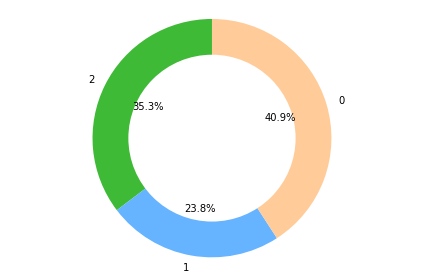

In [ ]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

# Preprocess

In [ ]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

# FastText Model

In [ ]:
EMBEDDING_FILE = 'wiki.fa.vec'

def import_with_gensim(file_address):
  # Creating the model
  ft_model = KeyedVectors.load_word2vec_format(file_address)
  # Getting the tokens
  ft_words = []
  for ft_word in ft_model.vocab:
      ft_words.append(ft_word)
  return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

In [ ]:
# Save:
df = pd.DataFrame(ft_words)
df.to_csv('ft_words.csv')
ft_model.save_word2vec_format('ft_model.bin', binary=True)

In [ ]:
# Load:
ft_words = pd.read_csv('ft_words.csv').values.tolist()
ft_moldel2 = gensim.models.KeyedVectors.load_word2vec_format('ft_model.bin', binary=True)

In [ ]:
embed_size = 300
embedding_list = list()
for w in ft_words:
  embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

## preprocessing:

In [ ]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [ ]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up:

In [ ]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [ ]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences:

In [ ]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [ ]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [ ]:
# We are going to set the embedding size to the pre-trained dimension as we are replicating it
nb_words = len(tokenizer.word_index)

# the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# With the newly created embedding matrix, we'll fill it up with the words that we have in both
# our own dictionary and loaded pre-trained embedding.
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
    # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    if word in ft_model.vocab:
        embedding_vector = ft_model[word]
        # and store inside the embedding matrix that we will train later on.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:   # Unknown words
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

total embedded: 19751 common words
Embedding matrix shape: (19751, 300)


In [ ]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models:

In [ ]:
# Prepare labels for categorical prediction
categorical_y_train = to_categorical(y_train, 3)
categorical_y_test = to_categorical(y_test, 3)

## B-LSTM Model:

In [ ]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(3, activation='softmax'))

In [ ]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         5925300   
                                                                 
 bidirectional (Bidirectiona  (None, None, 600)        1444800   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 600)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 300)               180300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0

In [ ]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, categorical_y_train, batch_size=batch_size_blstm, epochs=epochs_blstm, shuffle=True)

Epoch 1/5
230/230 [==============================] - 127s 520ms/step - loss: 0.8035 - categorical_accuracy: 0.6290
Epoch 2/5
230/230 [==============================] - 119s 518ms/step - loss: 0.5009 - categorical_accuracy: 0.7965
Epoch 3/5
230/230 [==============================] - 123s 536ms/step - loss: 0.4097 - categorical_accuracy: 0.8371
Epoch 4/5
230/230 [==============================] - 130s 569ms/step - loss: 0.3438 - categorical_accuracy: 0.8608
Epoch 5/5
230/230 [==============================] - 132s 575ms/step - loss: 0.2832 - categorical_accuracy: 0.8876


In [ ]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 80.000001


In [ ]:
# Save the Model:
model_blstm.save("BLSTM_model.h5")

In [ ]:
# load the Model:
from keras.models import load_model

model_blstm = load_model('BLSTM_model.h5')

In [ ]:
# Get prediction label
preds = model_blstm.predict(x_test_padded)
y_pred_blstm = np.argmax(preds, axis=1)

52/52 [==============================] - 5s 102ms/step


## CNN Model:

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(3, activation='softmax'))

In [ ]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 8

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 300)         5925300   
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 600)        1444800   
 nal)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, None, 64)          153664    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, None, 64)         

In [ ]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, categorical_y_train, batch_size=batch_size_cnn, epochs=epochs_cnn, shuffle=True)

Epoch 1/8
230/230 [==============================] - 163s 698ms/step - loss: 0.9880 - categorical_accuracy: 0.4725
Epoch 2/8
230/230 [==============================] - 169s 737ms/step - loss: 0.6387 - categorical_accuracy: 0.7327
Epoch 3/8
230/230 [==============================] - 172s 748ms/step - loss: 0.4810 - categorical_accuracy: 0.8086
Epoch 4/8
230/230 [==============================] - 167s 730ms/step - loss: 0.4067 - categorical_accuracy: 0.8383
Epoch 5/8
230/230 [==============================] - 173s 755ms/step - loss: 0.3595 - categorical_accuracy: 0.8542
Epoch 6/8
230/230 [==============================] - 163s 712ms/step - loss: 0.3113 - categorical_accuracy: 0.8740
Epoch 7/8
230/230 [==============================] - 170s 740ms/step - loss: 0.2599 - categorical_accuracy: 0.8967
Epoch 8/8
230/230 [==============================] - 170s 742ms/step - loss: 0.2181 - categorical_accuracy: 0.9128


In [ ]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 76.574922


In [ ]:
# Save the Model:
model_cnn.save("CNN_model.h5")

In [ ]:
# load the Model:
from keras.models import load_model

model_cnn = load_model('CNN_model.h5')

In [ ]:
# Get prediction label
preds = model_cnn.predict(x_test_padded)
y_pred_cnn = np.argmax(preds, axis=1)

52/52 [==============================] - 1s 15ms/step


# RNN:

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Embedding(max_features + 1, #Vocablury size
                                    embedding_vector_length, #Embedding size
                                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                                    trainable=False, #As embeddings are already available, we will not train this layer. It will act as lookup layer.
                                    input_length=maxlen) #Number of words in each review
         )
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
history=model.fit(X_train_pad,y_train,
          epochs=10,
          batch_size=32,          
          validation_data=(X_test_pad, y_test))

# GRU:

In [ ]:
# GRU with fasttext embeddings
model = Sequential()
model.add(Embedding(max_features+1,
                    embedding_vector_length, ### 50 here
                    weights=[embedding_matrix_fasttext],
                    input_length=maxlen, ### 1400 here
                    trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   

model.summary()

In [ ]:
history=model.fit(X_train_pad,y_train,
          epochs=10,
          batch_size=32,          
          validation_data=(X_test_pad, y_test))

# Attention:

In [ ]:
# Create attention masks for training
train_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in trainX:
  seq_mask = [float(i>0) for i in seq]
  train_attn_masks.append(seq_mask)

In [ ]:
# Create attention masks for Test
test_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in testX:
  seq_mask = [float(i>0) for i in seq]
  test_attn_masks.append(seq_mask)

In [ ]:
#Load Pre-trained Bert Model with a Binary Classification layer at the top.
#Huggingface library provides TFBertForSequenceClassification for the same
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

In [ ]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule 
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model.summary()

In [ ]:
train_x_data = {'input_ids': np.array(trainX), 'attention_mask': np.array(train_attn_masks)}
test_x_data = {'input_ids': np.array(testX), 'attention_mask': np.array(test_attn_masks)}

In [ ]:
model.fit(train_x_data, trainY, validation_data=(test_x_data, testY), batch_size=16, epochs=2)

# Evaluation:

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,test_pred))
print(classification_report(y_test,test_pred))

# Confusion Matrix:

In [ ]:
import tensorflow as tf

confusion = tf.math.confusion_matrix(labels= y_test, predictions=y_pred_cnn, num_classes=3)
print(confusion)

tf.Tensor(
[[491  53  94]
 [ 68 299  46]
 [ 85  32 467]], shape=(3, 3), dtype=int32)


In [ ]:
!pip install pretty-confusion-matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 92.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

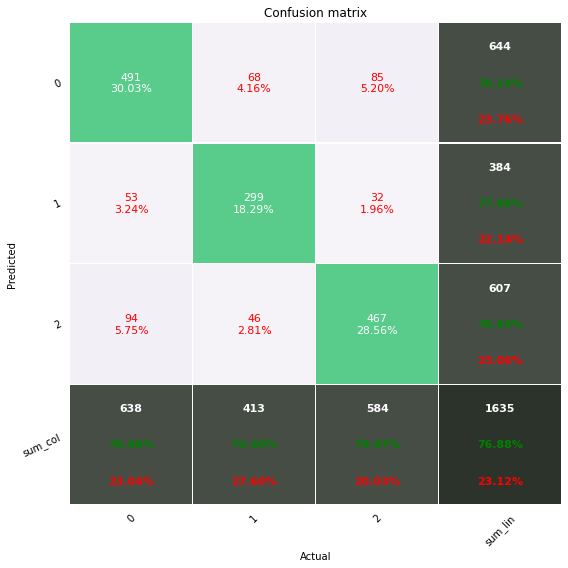

In [ ]:
from pretty_confusion_matrix import pp_matrix

confusion = np.asarray(confusion, np.int32)
df_cm = pd.DataFrame(confusion, index=range(3), columns=range(3))
# colormap: see this and choose your more dear
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [ ]:
confusion = tf.math.confusion_matrix(labels= y_test, predictions=y_pred_blstm, num_classes=3)
print(confusion)

tf.Tensor(
[[507  66  65]
 [ 50 328  35]
 [ 65  46 473]], shape=(3, 3), dtype=int32)


/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

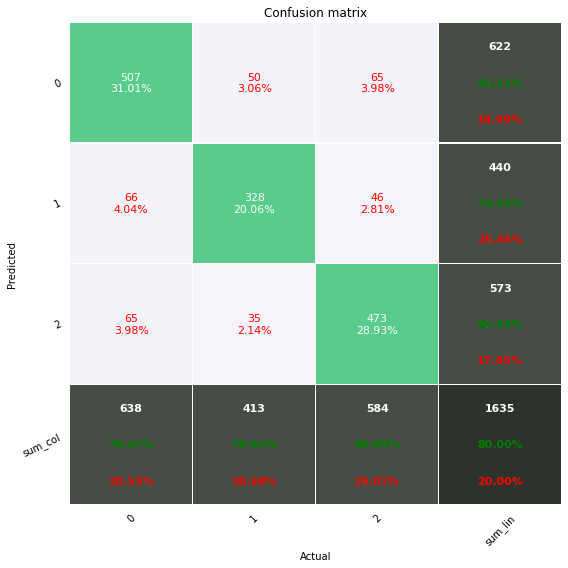

In [ ]:
from pretty_confusion_matrix import pp_matrix

confusion = np.asarray(confusion, np.int32)
df_cm = pd.DataFrame(confusion, index=range(3), columns=range(3))
# colormap: see this and choose your more dear
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

## F1 Score:

In [ ]:
print("(Weighted) F1 score of FastTextEmb B-LSTM model:")
f1_score(y_test, y_pred_blstm, average='weighted')

(Weighted) F1 score of FastTextEmb B-LSTM model:


0.8003381587975531

In [ ]:
print("(Weighted) F1 score of FastTextEmb CNN model:")
f1_score(y_test, y_pred_cnn, average='weighted')



(Weighted) F1 score of FastTextEmb CNN model:


0.7685401250855628